In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from collections import OrderedDict
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibrationDisplay

np.random.seed(42)

In [62]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from collections import OrderedDict
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibrationDisplay


class ELO:
    GAME_COLUMNS = [
        "timestamp",
        "winner",
        "winner_prev_elo",
        "loser",
        "loser_prev_elo",
        "win_prob",
        "site",
    ]

    def __init__(
        self,
        winners,
        losers,
        sites=None,
        ids=None,
        timestamps=None,
        k=20,
        elo_init=1500,
        elo_diff=400,
        seasonal_mean_reversion=0,
    ):
        self.k = k
        self.elo_init = elo_init
        self.elo_diff = elo_diff

        winners = list(winners)
        losers = list(losers)

        ELO.__check_valid_games__(winners, losers, ids, timestamps)
        ELO.__check_valid_params__(k, elo_init, elo_diff, seasonal_mean_reversion)

        # Assemble temporary empty dataframe to store ELOs
        if ids is None:
            self.ids = range(len(winners))
        else:
            self.ids = ids
        self.winners = winners
        self.losers = losers
        self.competitors = sorted(list(set(winners) | set(losers)))
        self.timestamps = timestamps
        self.seasonal_mean_reversion = seasonal_mean_reversion
        self.sites = sites
        if self.timestamps is not None:
            # sort arrays by timestamp
            self.ids, self.winners, self.losers, self.timestamps, self.sites = zip(
                *sorted(
                    zip(
                        self.ids, self.winners, self.losers, self.timestamps, self.sites
                    ),
                    key=lambda x: x[3],
                )
            )

    # Compute the ELO of every competitor after each match (37s original)
    # 0.04476022720336914s (without dataframe conversion)
    # 0.15063881874084473 (with dataframe conversion)
    def fit_fastest(self):
        start = time.time()
        elo_dict = OrderedDict(
            [(competitor, self.elo_init) for competitor in self.competitors]
        )
        game_array = np.vstack([self.ids, self.winners, self.losers, self.timestamps]).T
        elo_array = [np.ones(len(self.competitors)) * self.elo_init]
        game_probs, winner_prev_elos, loser_prev_elos = [], [], []
        current_year = self.timestamps[0].year if self.timestamps is not None else None
        for i, game in enumerate(game_array):
            game_id, winner, loser, timestamp = game
            winner_prev_elos.append(elo_dict[winner])
            loser_prev_elos.append(elo_dict[loser])
            if self.timestamps is not None and timestamp.year != current_year:
                current_year = timestamp.year
                mean_elo = np.mean(elo_array[-1])
                elo_dict = {
                    team: mean_elo
                    + (1 - self.seasonal_mean_reversion) * (elo - mean_elo)
                    for team, elo in elo_dict.items()
                }
            winner_elo, loser_elo = elo_dict[winner], elo_dict[loser]
            winner_new_elo, loser_new_elo, expected_outcome_prob = (
                ELO.compute_pairwise_elo(
                    winner_elo, loser_elo, elo_diff=self.elo_diff, k=self.k
                )
            )
            game_probs.append(expected_outcome_prob)
            elo_dict[winner], elo_dict[loser] = winner_new_elo, loser_new_elo
            elo_array.append(list(elo_dict.values()))
        self.elo_df = pd.concat(
            [
                pd.DataFrame(
                    np.vstack(
                        [
                            self.ids,
                            self.timestamps,
                            self.winners,
                            winner_prev_elos,
                            self.losers,
                            loser_prev_elos,
                            game_probs,
                            self.sites,
                        ]
                    ).T,
                    columns=[
                        "id",
                        "timestamp",
                        "winner",
                        "winner_prev_elo",
                        "loser",
                        "loser_prev_elo",
                        "win_prob",
                        "site",
                    ],
                ).set_index("id"),
                pd.DataFrame(elo_array[1:], columns=self.competitors, index=self.ids),
            ],
            axis=1,
        )
        self.convert_column_dtypes()
        print("Computed elos in", time.time() - start, "seconds.")

    # Show a calibration curve of the ELO output probabilities after fitting
    def show_calibration(self, start_year=2018, A=5, B=0.2):
        d = self.elo_df.loc[self.elo_df.timestamp > str(start_year)]
        win_sample = d.sample(frac=0.5)
        lose_sample = d.drop(win_sample.index)
        p_true = [1] * len(win_sample) + [0] * len(lose_sample)
        p_pred = win_sample.win_prob.tolist() + (1 - lose_sample.win_prob).tolist()
        p_pred = np.array(p_pred)

        def sigmoid(x, A, B):
            return 1 / (1 + np.exp(A * x + B))

        def invsigmoid(x, A, B=1 / 2):
            return -(1 / A) * np.log((1 + B) / (x + B / 2) - 1) + 1 / 2

        prob_true, prob_pred = calibration_curve(
            p_true, invsigmoid(p_pred, A, B), n_bins=20, strategy="uniform"
        )
        # prob_true, prob_pred = calibration_curve(p_true, p_pred, n_bins=20, strategy='uniform')
        plt.figure(dpi=300)
        CalibrationDisplay(prob_true, prob_pred, p_pred).plot()
        plt.suptitle("Calibration Curve with Inverse Sigmoid")
        plt.title(
            f"A={A}, B={B}, start_year={start_year}, k={self.k}, elo_init={self.elo_init}, elo_diff={self.elo_diff}, smr={self.seasonal_mean_reversion}"
        )
        plt.grid()

    def convert_column_dtypes(self):
        self.elo_df = self.elo_df.astype(
            {
                "winner": "int64",
                "winner_prev_elo": "float64",
                "loser": "int64",
                "loser_prev_elo": "float64",
                "win_prob": "float64",
                "site": "object",
            }
        )

    def check_elo_home_boost(
        self, boost_high=100, boost_low=0, boost_step=1, since=None
    ):
        since_df = self.get_elos_since(since)
        accuracies = []
        for d in range(boost_low, boost_high, boost_step):
            adj = np.where(
                since_df.site == "home",
                since_df.winner_prev_elo + d,
                np.where(
                    since_df.site == "away",
                    since_df.winner_prev_elo - d,
                    since_df.winner_prev_elo,
                ),
            )
            accuracies.append((d, np.mean(adj > since_df.loser_prev_elo)))
        return accuracies

    def get_home_elo_advantage(self):
        home_win_pct = self.get_home_win_pct()
        return np.log(home_win_pct / (1 - home_win_pct)) * self.elo_diff

    def get_home_win_pct(self):
        n_home_wins = sum(self.elo_df.site == "home")
        n_away_wins = sum(self.elo_df.site == "away")
        return n_home_wins / (n_home_wins + n_away_wins)

    def get_accuracy(self, since=None):
        since_df = self.get_elos_since(since)
        n_correct = sum(since_df.win_prob > 0.5)
        return n_correct / len(since_df)

    def get_elos_since(self, since=None):
        since = str(since) if since else str(self.elo_df.timestamp.min().year)
        return self.elo_df.loc[self.elo_df.timestamp >= since]

    @staticmethod
    def compute_pairwise_elo(winner_elo, loser_elo, elo_diff, k):
        expected_outcome_prob = ELO.compute_expected_outcome_prob(
            winner_elo, loser_elo, elo_diff=elo_diff
        )
        return (
            winner_elo + k * (1 - expected_outcome_prob),
            loser_elo - k * (1 - expected_outcome_prob),
            expected_outcome_prob,
        )

    @staticmethod
    def compute_expected_outcome_prob(elo1, elo2, elo_diff=400):
        return 1 / (1 + 10 ** ((elo2 - elo1) / elo_diff))

    @staticmethod
    def __check_valid_params__(k, elo_init, elo_diff, seasonal_mean_reversion):
        assert isinstance(k, int) and k > 0
        assert isinstance(elo_init, int) and elo_init > 0
        assert isinstance(elo_diff, int) and elo_diff > 0
        assert (
            isinstance(seasonal_mean_reversion, float) or seasonal_mean_reversion == 0
        ) and seasonal_mean_reversion <= 1

    @staticmethod
    def __check_valid_games__(winners, losers, ids, timestamps):
        # assert proper data types
        assert pd.api.types.is_list_like(winners)
        assert pd.api.types.is_list_like(losers)
        assert ids is None or pd.api.types.is_list_like(ids)
        assert timestamps is None or pd.api.types.is_list_like(timestamps)

        # check that winners, losers, ids, and timestamps have the same length
        assert len(winners) == len(losers)
        assert ids is None or len(ids) == len(winners)
        assert timestamps is None or len(timestamps) == len(winners)

        # check that all ids are unique
        assert ids is None or len(set(ids)) == len(ids)

        # check that no teams play against themselves
        for i in range(len(winners)):
            assert winners[i] != losers[i]

        # check that the timestamps are valid
        if timestamps is not None:
            for timestamp in timestamps:
                try:
                    pd.to_datetime(timestamp)
                except ValueError:
                    raise ValueError("Invalid timestamp: {}".format(timestamp))

    def show_elos(self, since=None):
        if since is not None:
            return self.elo_df.loc[self.elo_df.timestamp >= str(since)]
        return self.elo_df

    def show_games(self, since=None):
        if since is not None:
            return self.elo_df.loc[self.elo_df.timestamp >= str(since)][
                ELO.GAME_COLUMNS
            ]
        return self.elo_df[ELO.GAME_COLUMNS]

In [3]:
games = pd.read_csv("games_2011_to_2023.csv", parse_dates=["date"])
wins = games.loc[games.result == "W"]
schools = pd.read_csv(
    "general_data/schools.csv",
    skiprows=1,
    header=None,
    names=["school_id", "school_name"],
).set_index("school_id")
elo_df = (
    wins[["date", "contest_id", "site", "school_id", "opponent_school_id"]]
    .sort_values(by="date")
    .set_index("date")
)
elo_df.columns = ["id", "site", "winner", "loser"]

Computed elos in 0.17038941383361816 seconds.


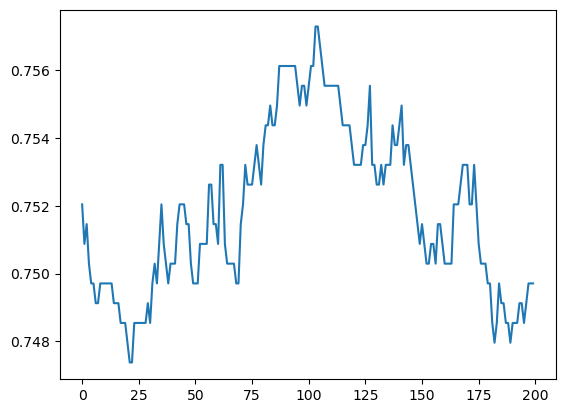

In [69]:
sd = ELO(
    elo_df.winner,
    elo_df.loser,
    sites=elo_df.site,
    ids=elo_df.id,
    timestamps=elo_df.index,
    k=150,
    elo_init=1500,
    elo_diff=400,
    seasonal_mean_reversion=-0.1,
)
sd.fit_fastest()
# df = sd.show_games(2018)
a = sd.check_elo_home_boost(since=2020, boost_high=200)
plt.plot(*zip(*a))

In [51]:
sd.get_home_elo_advantage()

121.17246563517983

In [8]:
df["winner_school"] = df.winner.apply(lambda x: schools.loc[x].school_name)
df["loser_school"] = df.loser.apply(lambda x: schools.loc[x].school_name)

In [9]:
df.loc[
    (df.site == "home")
    & (df.winner_prev_elo < df.loser_prev_elo)
    & (df.winner_prev_elo > df.loser_prev_elo - 100)
].shape

(241, 9)

In [10]:
df.loc[
    (df.site == "away")
    & (df.winner_prev_elo > df.loser_prev_elo)
    & (df.winner_prev_elo < df.loser_prev_elo + 100)
].shape

(272, 9)

In [18]:
dfh = df.loc[df.site == "home"]
dfa = df.loc[df.site == "away"]

In [41]:
counts, bins = np.histogram(
    dfh.winner_prev_elo - dfh.loser_prev_elo, bins=np.arange(-600, 601, 50)
)

(array([  0,   0,   0,   2,   1,   1,   9,  22,  38,  70, 121, 120, 194,
        199, 180, 155, 130,  97,  77,  46,  31,  20,   9,   2], dtype=int64),
 array([-600, -550, -500, -450, -400, -350, -300, -250, -200, -150, -100,
         -50,    0,   50,  100,  150,  200,  250,  300,  350,  400,  450,
         500,  550,  600]))

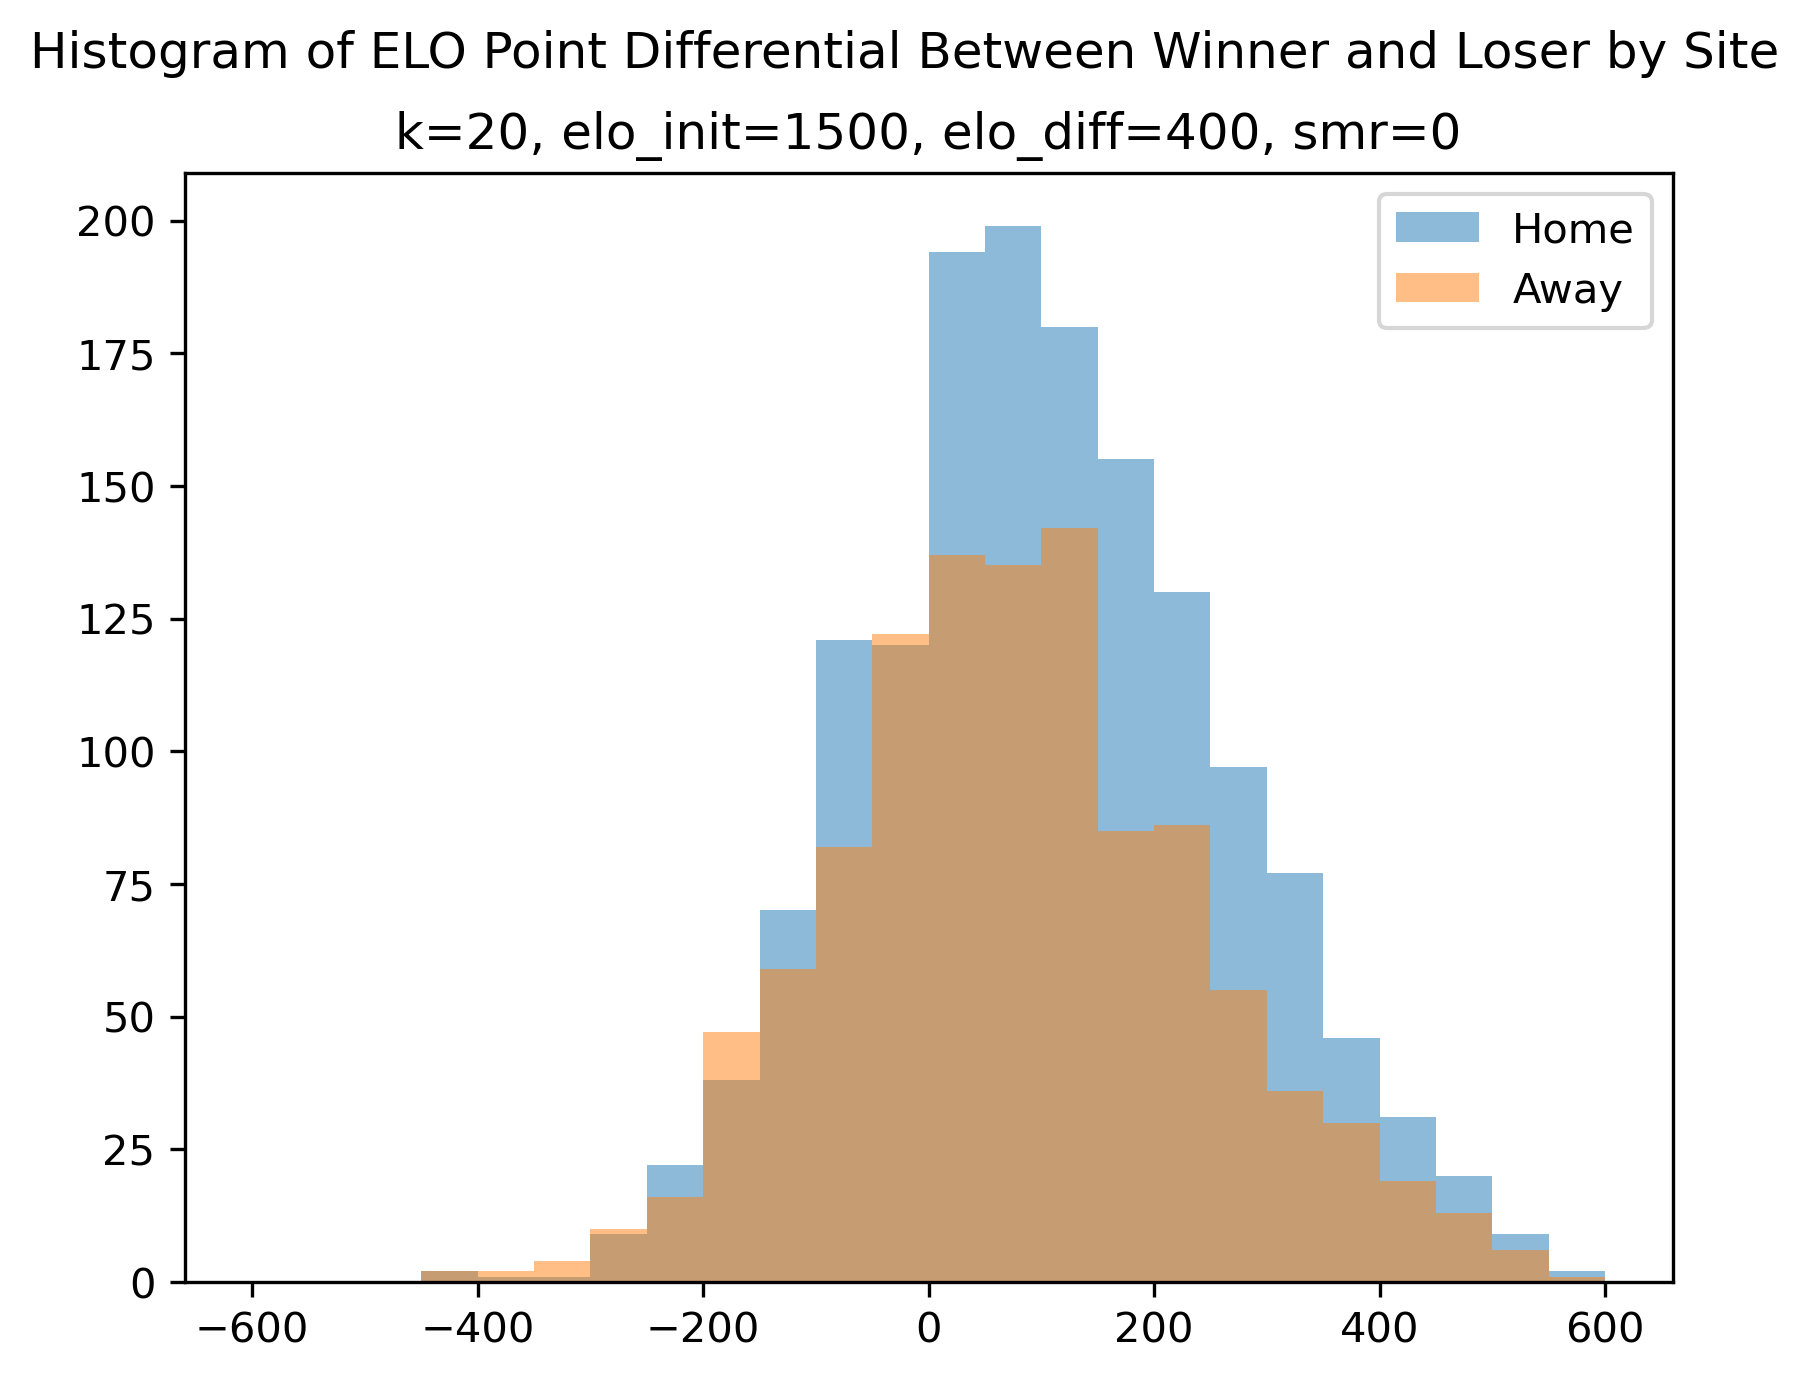

In [48]:
hist_bins = np.arange(-600, 601, 50)
plt.figure(dpi=300)
plt.hist(
    dfh.winner_prev_elo - dfh.loser_prev_elo, bins=hist_bins, alpha=0.5, label="Home"
)
plt.hist(
    dfa.winner_prev_elo - dfa.loser_prev_elo, bins=hist_bins, alpha=0.5, label="Away"
)
plt.suptitle("Histogram of ELO Point Differential Between Winner and Loser by Site")
plt.title("k=20, elo_init=1500, elo_diff=400, smr=0")
plt.legend()

In [16]:
np.mean(np.abs(df.winner_prev_elo - df.loser_prev_elo))

145.4155637962851

In [17]:
np.mean( > df.loser_prev_elo)

SyntaxError: invalid syntax (3579548953.py, line 1)

In [ ]:
df.timestamp.min().year

2018

In [ ]:
df.site.value_counts()

site
home       1525
away       1089
neutral     174
Name: count, dtype: int64

In [ ]:
df.loc[df.site == "home"]

,timestamp,winner,winner_prev_elo,loser,loser_prev_elo,win_prob,site,14,52,62,...,738,739,741,746,748,813,1320,11504,19651,30136
142840.0,2018-02-03,193,1731.277269,721,1603.913132,0.6755,home,1750.282089,1367.209956,1472.431707,...,1402.157804,1590.783461,1153.284089,1624.385770,1263.156234,1690.031228,1428.60073,1500.00000,1434.394259,1500.00000
142847.0,2018-02-03,81,1556.431853,381,1231.741353,0.86635,home,1750.282089,1367.209956,1472.431707,...,1402.157804,1590.783461,1153.284089,1624.385770,1263.156234,1690.031228,1428.60073,1500.00000,1434.394259,1500.00000
142836.0,2018-02-03,68,1544.362418,556,1465.065133,0.612177,home,1750.282089,1367.209956,1472.431707,...,1402.157804,1590.783461,1153.284089,1624.385770,1263.156234,1690.031228,1428.60073,1500.00000,1434.394259,1500.00000
142835.0,2018-02-03,352,1528.726303,471,1201.891213,0.867773,home,1750.282089,1367.209956,1472.431707,...,1402.157804,1590.783461,1153.284089,1624.385770,1263.156234,1690.031228,1428.60073,1500.00000,1434.394259,1500.00000
142837.0,2018-02-03,587,1556.138247,579,1435.833736,0.666529,home,1750.282089,1367.209956,1472.431707,...,1402.157804,1590.783461,1153.284089,1624.385770,1263.156234,1690.031228,1428.60073,1500.00000,1434.394259,1500.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2433948.0,2023-05-13,513,1828.511361,732,1561.021544,0.823435,home,1530.501514,1361.176001,1405.930448,...,1584.048434,1664.209548,1159.890639,1860.370115,1144.469566,1768.852620,1428.60073,1389.49799,1530.916038,1403.51702
2433937.0,2023-05-13,746,1860.370115,575,1664.281157,0.755613,home,1530.501514,1361.176001,1405.930448,...,1584.048434,1664.209548,1159.890639,1865.257846,1144.469566,1768.852620,1428.60073,1389.49799,1530.916038,1403.51702
2433946.0,2023-05-14,539,1653.749557,554,1698.175111,0.436413,home,1530.501514,1361.176001,1405.930448,...,1584.048434,1664.209548,1159.890639,1865.257846,1144.469566,1768.852620,1428.60073,1389.49799,1530.916038,1403.51702
2433949.0,2023-05-14,322,1698.354536,81,1537.837589,0.715858,home,1530.501514,1361.176001,1405.930448,...,1584.048434,1664.209548,1159.890639,1865.257846,1144.469566,1768.852620,1428.60073,1389.49799,1530.916038,1403.51702
